In [1]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Cross-validated RMSE: 1.31 ± 0.04
Cross-validated MAE: 0.13 ± 0.02
Cross-validated R²: 0.78 ± 0.02


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training RMSE: 0.88
Training MAE: 0.09
Training R²: 0.89


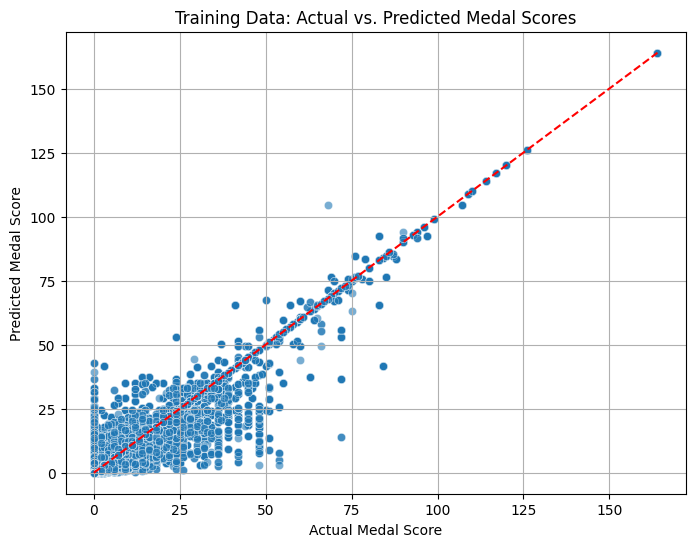

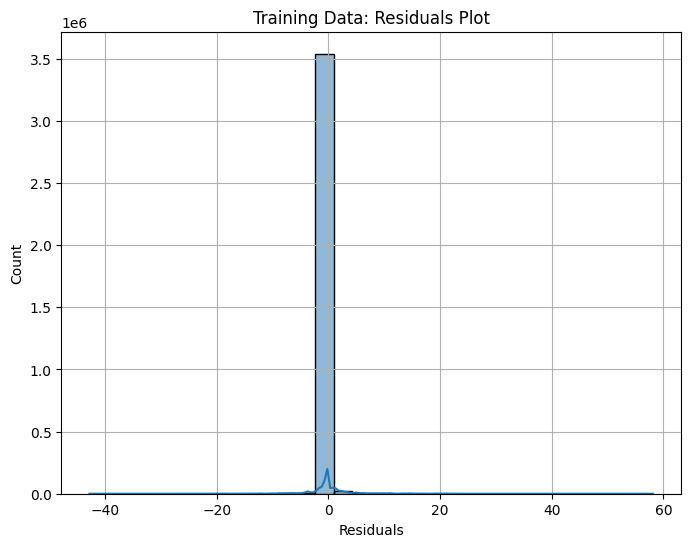

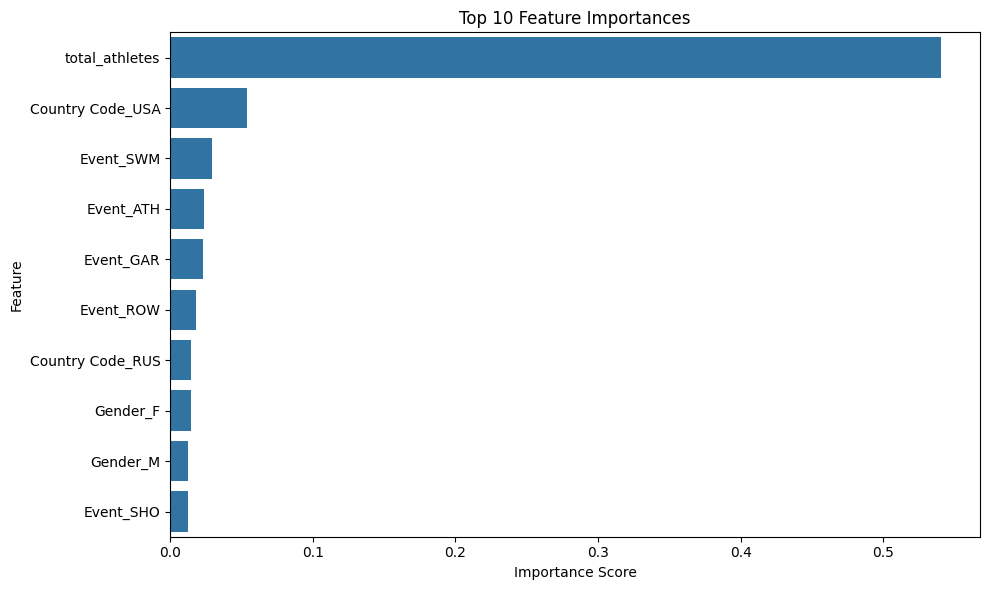

/Users/chris/MCM_2025_C/Data/data_by_year_merged/2028.csv does not exist.


In [2]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load and Integrate Data
def load_and_concatenate_data(folder_path):
    """
    Load all CSV files from the specified folder, extract the year from filename,
    and concatenate into a single DataFrame.
    """
    all_files = glob.glob(os.path.join(folder_path, "*.csv"))
    df_list = []
    for file in all_files:
        try:
            year_str = os.path.basename(file).split('.')[0]
            year = int(year_str)  # Extract year from filename
        except ValueError:
            print(f"Filename {file} does not start with a valid year. Skipping.")
            continue
        temp_df = pd.read_csv(file, usecols=['Country Code', 'Gender', 'Event', 'bronze', 'silver', 'gold', 'total athletes'])
        temp_df['Year'] = year
        df_list.append(temp_df)
    if not df_list:
        raise ValueError("No valid CSV files found in the directory.")
    concatenated_df = pd.concat(df_list, ignore_index=True)
    return concatenated_df

# 2. Preprocess Data
def preprocess_data(df):
    """
    Preprocess the DataFrame:
    - Handle missing values
    - Ensure categorical columns are strings
    - Encode categorical variables
    - Create composite target score
    """
    # Fill missing values with 0
    df.fillna(0, inplace=True)
    
    # Define categorical features
    categorical_features = ['Country Code', 'Gender', 'Event']
    
    # Ensure all categorical features are strings to prevent mixed types
    for col in categorical_features:
        df[col] = df[col].astype(str)
    
    # Initialize OneHotEncoder with updated parameter
    try:
        encoder = OneHotEncoder(drop='first', sparse_output=False)
    except TypeError:
        # For scikit-learn versions < 1.2
        encoder = OneHotEncoder(drop='first', sparse=False)
    
    encoded_cats = encoder.fit_transform(df[categorical_features])
    encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_features))
    
    # Concatenate encoded features with the original DataFrame
    df = pd.concat([df.reset_index(drop=True), encoded_cat_df.reset_index(drop=True)], axis=1)
    
    # Drop original categorical columns
    df.drop(columns=categorical_features, inplace=True)
    
    # Rename 'total athletes' to 'total_athletes' for consistency
    if 'total athletes' in df.columns:
        df.rename(columns={'total athletes': 'total_athletes'}, inplace=True)
    
    # Create composite target score: Gold=3, Silver=2, Bronze=1
    df['Medal_Score'] = (df['gold'] * 3) + (df['silver'] * 2) + (df['bronze'] * 1)
    
    return df, encoder

# 3. Train Model
def train_model(X, y):
    """
    Train a RandomForestRegressor with Time Series Cross-Validation.
    Returns the trained model.
    """
    # Initialize TimeSeriesSplit with fewer splits to reduce runtime
    tscv = TimeSeriesSplit(n_splits=3)
    
    # Initialize RandomForestRegressor with n_jobs=-1 to utilize all cores
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    
    # Lists to store metrics
    rmse_scores = []
    mae_scores = []
    r2_scores = []
    
    # Cross-validation
    for train_index, test_index in tscv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
        
        # Train the model
        rf.fit(X_train_cv, y_train_cv)
        
        # Predict on test set
        y_pred_cv = rf.predict(X_test_cv)
        
        # Calculate metrics
        rmse = mean_squared_error(y_test_cv, y_pred_cv, squared=False)
        mae = mean_absolute_error(y_test_cv, y_pred_cv)
        r2 = r2_score(y_test_cv, y_pred_cv)
        
        rmse_scores.append(rmse)
        mae_scores.append(mae)
        r2_scores.append(r2)
    
    # Print cross-validation metrics
    print(f"Cross-validated RMSE: {np.mean(rmse_scores):.2f} ± {np.std(rmse_scores):.2f}")
    print(f"Cross-validated MAE: {np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f}")
    print(f"Cross-validated R²: {np.mean(r2_scores):.2f} ± {np.std(r2_scores):.2f}")
    
    # Fit the model on the entire dataset
    rf.fit(X, y)
    
    return rf

# 4. Evaluate on Training Data
def evaluate_on_training(model, X, y):
    """
    Evaluate the trained model on the training data.
    """
    y_pred = model.predict(X)
    rmse = mean_squared_error(y, y_pred, squared=False)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    print(f"Training RMSE: {rmse:.2f}")
    print(f"Training MAE: {mae:.2f}")
    print(f"Training R²: {r2:.2f}")
    
    return y_pred

# 5. Plotting Functions
def plot_actual_vs_predicted(y_true, y_pred, title="Actual vs. Predicted Medal Scores"):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # Diagonal line
    plt.xlabel("Actual Medal Score")
    plt.ylabel("Predicted Medal Score")
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_residuals(y_true, y_pred, title="Residuals Plot"):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True, bins=30)
    plt.xlabel("Residuals")
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_feature_importances(model, feature_names, top_n=10, title="Top Feature Importances"):
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n))
    plt.title(title)
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

# 6. Predict and Allocate Medals (Vectorized)
def predict_and_allocate_medals_vectorized(model, encoder, folder_path, target_year=2028):
    """
    Predict medal scores for the target year and allocate Gold, Silver, Bronze medals per event using vectorized operations.
    """
    # Load target year data
    target_file = os.path.join(folder_path, f"{target_year}.csv")
    if not os.path.exists(target_file):
        raise FileNotFoundError(f"{target_file} does not exist.")
    
    target_df = pd.read_csv(target_file, usecols=['Country Code', 'Gender', 'Event', 'bronze', 'silver', 'gold', 'total athletes'])
    target_df['Year'] = target_year
    
    # Fill missing values with 0
    target_df.fillna(0, inplace=True)
    
    # Define categorical features
    categorical_features = ['Country Code', 'Gender', 'Event']
    
    # Ensure all categorical features are strings
    for col in categorical_features:
        target_df[col] = target_df[col].astype(str)
    
    # Encode categorical variables using the same encoder
    try:
        encoded_cats = encoder.transform(target_df[categorical_features])
    except ValueError as ve:
        print(f"Error during encoding: {ve}")
        raise
    
    encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_features))
    
    # Concatenate encoded features with the original DataFrame
    target_df = pd.concat([target_df.reset_index(drop=True), encoded_cat_df.reset_index(drop=True)], axis=1)
    
    # Drop original categorical columns
    target_df.drop(columns=categorical_features, inplace=True)
    
    # Rename 'total athletes' to 'total_athletes' for consistency
    if 'total athletes' in target_df.columns:
        target_df.rename(columns={'total athletes': 'total_athletes'}, inplace=True)
    
    # Define feature columns (ensure they match training features)
    feature_cols = ['total_athletes'] + list(encoded_cat_df.columns)
    missing_features = set(feature_cols) - set(target_df.columns)
    if missing_features:
        # Add missing feature columns with default value 0
        for feature in missing_features:
            target_df[feature] = 0
        print(f"Added missing features: {missing_features}")
    
    X_target = target_df[feature_cols]
    
    # Predict Medal_Score
    target_df['Predicted_Score'] = model.predict(X_target)
    
    # Sort by Event and Predicted_Score
    target_df_sorted = target_df.sort_values(['Event', 'Predicted_Score'], ascending=[True, False])
    
    # Assign ranks within each event
    target_df_sorted['Rank'] = target_df_sorted.groupby('Event')['Predicted_Score'].rank(method='first', ascending=False)
    
    # Assign medals based on rank
    medal_assignments_df = target_df_sorted[target_df_sorted['Rank'] <= 3].copy()
    medal_assignments_df['Medal'] = medal_assignments_df['Rank'].map({1: 'Gold', 2: 'Silver', 3: 'Bronze'})
    
    # Select relevant columns
    medal_assignments_df = medal_assignments_df[['Year', 'Event', 'Medal', 'Country Code']]
    
    # Rename for consistency
    medal_assignments_df.rename(columns={'Country Code': 'Country_Code'}, inplace=True)
    
    return medal_assignments_df

# 7. Additional Plot: Medal Distribution per Country
def plot_medal_distribution(allocations_df):
    """
    Plot the number of Gold, Silver, and Bronze medals per country.
    """
    medal_counts = allocations_df.groupby(['Country_Code', 'Medal']).size().reset_index(name='Count')
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Count', y='Country_Code', hue='Medal', data=medal_counts)
    plt.title("Medal Distribution per Country for 2028 Olympics")
    plt.xlabel("Number of Medals")
    plt.ylabel("Country Code")
    plt.legend(title='Medal Type')
    plt.tight_layout()
    plt.show()

# 8. Main Execution
def main():
    data_folder = "/Users/chris/MCM_2025_C/Data/data_by_year_merged"  # Path to your data folder
    target_year = 2028
    
    # Load and concatenate data
    try:
        data = load_and_concatenate_data(data_folder)
    except ValueError as ve:
        print(f"Error loading data: {ve}")
        return
    
    # Preprocess data
    processed_df, encoder = preprocess_data(data)
    
    # Define features and target
    # Exclude non-feature columns: 'gold', 'silver', 'bronze', 'Medal_Score', 'Year'
    non_feature_cols = ['gold', 'silver', 'bronze', 'Medal_Score', 'Year']
    feature_cols = [col for col in processed_df.columns if col not in non_feature_cols]
    
    X = processed_df[feature_cols]
    y = processed_df['Medal_Score']
    
    # Sort data chronologically if 'Year' exists
    if 'Year' in processed_df.columns:
        sorted_indices = processed_df['Year'].argsort()
        X_sorted = X.iloc[sorted_indices]
        y_sorted = y.iloc[sorted_indices]
    else:
        X_sorted = X
        y_sorted = y
    
    # Train model
    model = train_model(X_sorted, y_sorted)
    
    # Evaluate on training data
    y_train_pred = model.predict(X_sorted)
    rmse_train = mean_squared_error(y_sorted, y_train_pred, squared=False)
    mae_train = mean_absolute_error(y_sorted, y_train_pred)
    r2_train = r2_score(y_sorted, y_train_pred)
    
    print(f"Training RMSE: {rmse_train:.2f}")
    print(f"Training MAE: {mae_train:.2f}")
    print(f"Training R²: {r2_train:.2f}")
    
    # Plot Actual vs. Predicted
    plot_actual_vs_predicted(y_sorted, y_train_pred, title="Training Data: Actual vs. Predicted Medal Scores")
    
    # Plot Residuals
    plot_residuals(y_sorted, y_train_pred, title="Training Data: Residuals Plot")
    
    # Plot Feature Importances
    plot_feature_importances(model, feature_cols, top_n=10, title="Top 10 Feature Importances")
    
    # Predict and allocate medals for the target year using vectorized allocation
    try:
        allocations = predict_and_allocate_medals_vectorized(model, encoder, data_folder, target_year)
    except FileNotFoundError as fnfe:
        print(fnfe)
        return
    except ValueError as ve:
        print(f"Value Error: {ve}")
        return
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return
    
    # Display the first 20 medal assignments
    print("\nMedal Assignments Preview:")
    print(allocations.head(20))
    
    # Save the allocations to a CSV file
    output_file = f"medal_allocations_{target_year}.csv"
    allocations.to_csv(output_file, index=False)
    print(f"\nMedal allocations for {target_year} saved to '{output_file}'.")
    
    # Plot Medal Distribution per Country
    plot_medal_distribution(allocations)

if __name__ == "__main__":
    main()
